In [53]:
import numpy as np
import random
# Importing standard Qiskit libraries
from qiskit import *
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_state_city
from ibm_quantum_widgets import *

In [54]:
#3-coloring vertex coloring problem using grover algorithm (np-problem in classical computer, still np in this algorithm but 
#improves the bruce-force algorithm by (theoretically) square-rooting numbers of iterations)

In [55]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model

In [56]:
#條誇號參數絕定其error
noise_model = get_noise(0.01)

In [57]:
def diffuser(n):
    qc = QuantumCircuit(n)
    for qubit in range(n):
        qc.h(qubit)
    for qubit in range(n):
        qc.x(qubit)
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)
    qc.h(n-1)
    
    for qubit in range(n):
        qc.x(qubit)
    for qubit in range(n):
        qc.h(qubit)
    
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [58]:
def vertexcolor_oracle(qc, v_list, e_list):
    #qc.x(in_qubits_v[3])
    #qc.x(in_qubits_v[4])
    #qc.x(in_qubits_v[7])


    for j in range(3*len(e_list)):
        qc.x(ax_qubits_e[j])
    for j in range(len(v_list)):
        qc.x(check4_qubits[j])

    #check two number are not same
    i = 0
    for e in e_list:
        qc.cx(in_qubits_v[2*e[0]], ax_qubits_e[i])
        qc.cx(in_qubits_v[2*e[1]], ax_qubits_e[i])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]+1], ax_qubits_e[i+1])
        qc.cx(in_qubits_v[2*e[1]+1], ax_qubits_e[i+1])
        qc.barrier()
        qc.ccx(ax_qubits_e[i], ax_qubits_e[i+1], ax_qubits_e[i+2])
        qc.barrier()
        i += 3


    #check the number is not 4
    for j in range(len(v_list)):
        qc.ccx(in_qubits_v[2*j], in_qubits_v[2*j+1], check4_qubits[j])
    qc.barrier()


    #target
    check_qubitslist = []
    for j in range(len(e_list)):
        check_qubitslist.append(ax_qubits_e[j*3+2])
    for j in range(len(v_list)):
        check_qubitslist.append(check4_qubits[j])
    qc.mct(check_qubitslist, target[0])
    qc.barrier()

    #reverse part

    #check the number is not 4
    for j in range(len(v_list)):
        qc.ccx(in_qubits_v[2*j], in_qubits_v[2*j+1], check4_qubits[j])
    qc.barrier()

    #check two number are not same
    e_list_r = e_list[::-1]
    i = 3*(len(e_list) - 1)
    for e in e_list_r:
        qc.ccx(ax_qubits_e[i], ax_qubits_e[i+1], ax_qubits_e[i+2])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]+1], ax_qubits_e[i+1])
        qc.cx(in_qubits_v[2*e[1]+1], ax_qubits_e[i+1])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]], ax_qubits_e[i])
        qc.cx(in_qubits_v[2*e[1]], ax_qubits_e[i])
        qc.barrier()
        i -= 3

    for j in range(3*len(e_list)):
        qc.x(ax_qubits_e[j])
    for j in range(len(v_list)):
        qc.x(check4_qubits[j])
    qc.barrier()

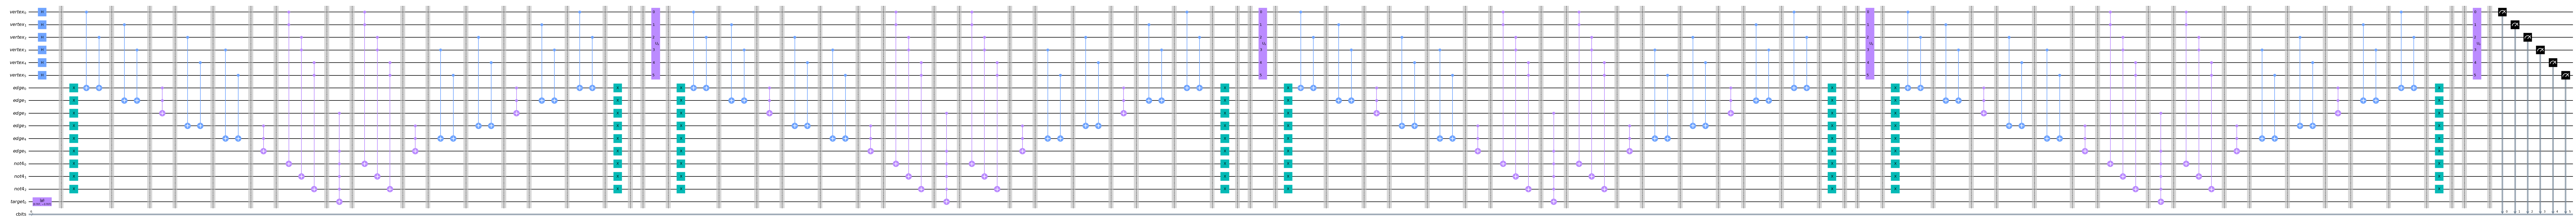

In [59]:
#example (v為vertex, e為edge)
# ex 1 
#v_list = [0,1,2,3]
#e_list = [[0,1],[1,2],[1,3], [0,1]]

#ex 2
v_list = [0,1,2]
e_list = [[0,1], [1,2]]

# choose n prob.
top_n = 14

#input vertex qubits
in_qubits_v = QuantumRegister(2*len(v_list), name = 'vertex')
#auxiliary qubits (edge)
ax_qubits_e = QuantumRegister(3*len(e_list), name = 'edge')
#因為這裡是做3-coloring，第四個顏色的答案要捨去
check4_qubits = QuantumRegister(len(v_list), name = 'not4')
#target qubit
target = QuantumRegister(1, name = 'target')
#cbit:輸出結果
cbits = ClassicalRegister(2*len(v_list), name = 'cbits')


qc = QuantumCircuit(in_qubits_v, ax_qubits_e, check4_qubits, target, cbits)

#initialize 'target' as |->
qc.initialize([1, -1]/np.sqrt(2), target)

#parallelization
qc.h(in_qubits_v)
qc.barrier()

#取的次數視情況而定，這裡取4
#xx = random.randint(1, 4)

xx = 4

for jj in range(xx):
    #oracle
    vertexcolor_oracle(qc, v_list, e_list)
    qc.barrier()

    #diffuser
    qc.append(diffuser(2*len(v_list)), list(range(2*len(v_list))))
    qc.barrier()

#可以自行決定要run幾次(每個例子都會有不一樣的最佳次數)


#measure
qc.measure(in_qubits_v, cbits)

qc.draw(output='mpl', fold = -1)

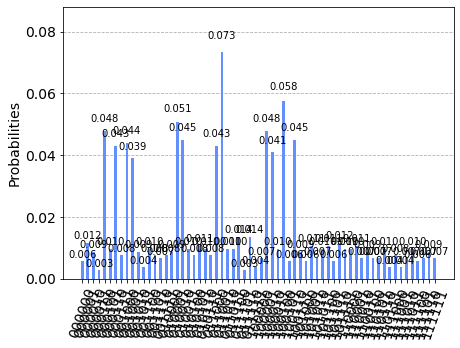

In [60]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
qobj = assemble(transpiled_qc)
result = qasm_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

[['011001', 75], ['100100', 59], ['010001', 52], ['100001', 49], ['000100', 49], ['010010', 46], ['100110', 46], ['001000', 45], ['011000', 44], ['000110', 44], ['100010', 42], ['001001', 40], ['011110', 14], ['011100', 14], ['101110', 12], ['000001', 12], ['010101', 11], ['101100', 11], ['110001', 11], ['101001', 11], ['010110', 10], ['101111', 10], ['100011', 10], ['110110', 10], ['011011', 10], ['111011', 10], ['001100', 10], ['011010', 10], ['110000', 10], ['000101', 10], ['010011', 10], ['101011', 10], ['100111', 9], ['110011', 9], ['000010', 9], ['001010', 9], ['010000', 9], ['111110', 9], ['111000', 8], ['001111', 8], ['010100', 8], ['010111', 8], ['001101', 8], ['000111', 8], ['110101', 7], ['110100', 7], ['111010', 7], ['111111', 7], ['110010', 7], ['111101', 7], ['101010', 7], ['001110', 7], ['100000', 7], ['111100', 6], ['100101', 6], ['101101', 6], ['101000', 6], ['000000', 6], ['001011', 4], ['011111', 4], ['110111', 4], ['111001', 4], ['011101', 3], ['000011', 3]]


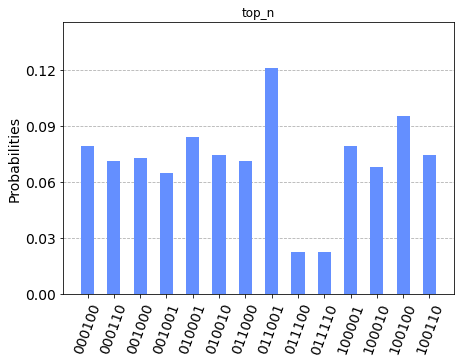

In [61]:
p1 = []
pause = result.get_counts()
pause.clear()
di = dict.fromkeys(counts)
for i in di.keys():
    p1.append([i,counts.get(i)])
p1.sort(key = lambda s: s[1],reverse = True)
print(p1)
for i in range(top_n):
        a = p1[i]
        pause.setdefault(a[0],a[1])
plot_histogram(pause, title="top_n",bar_labels = False)

In [62]:
print(counts)

{'110101': 7, '001011': 4, '110100': 7, '011111': 4, '100111': 9, '111000': 8, '111010': 7, '011101': 3, '111111': 7, '100010': 42, '001111': 8, '010010': 46, '110011': 9, '111100': 6, '110111': 4, '001001': 40, '010110': 10, '110010': 7, '000011': 3, '010101': 11, '101111': 10, '100101': 6, '100001': 49, '100100': 59, '011110': 14, '010100': 8, '011000': 44, '100011': 10, '010111': 8, '101110': 12, '000100': 49, '010001': 52, '000010': 9, '001010': 9, '101100': 11, '110110': 10, '011011': 10, '001000': 45, '111101': 7, '011001': 75, '001101': 8, '000001': 12, '101101': 6, '000111': 8, '011100': 14, '110001': 11, '010000': 9, '111011': 10, '001100': 10, '011010': 10, '101010': 7, '111110': 9, '111001': 4, '100110': 46, '110000': 10, '001110': 7, '101000': 6, '101001': 11, '000110': 44, '000101': 10, '010011': 10, '100000': 7, '101011': 10, '000000': 6}


In [63]:
aer_sim = Aer.get_backend('qasm_simulator')

t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots = 1000)
results = aer_sim.run(qobj, noise_model=noise_model, shots=1000).result()
noisy_counts = results.get_counts()
print(noisy_counts)

{'000111': 3, '000011': 5, '011101': 9, '001011': 4, '010101': 5, '001101': 8, '110100': 9, '100111': 2, '101110': 4, '101111': 10, '101001': 10, '101101': 7, '110110': 6, '011011': 9, '000000': 7, '101011': 6, '111010': 5, '011100': 8, '110001': 12, '001100': 14, '010000': 5, '111011': 6, '101100': 8, '010100': 8, '011000': 51, '010001': 51, '000100': 40, '010111': 13, '100011': 9, '111100': 8, '110011': 10, '001000': 57, '111111': 4, '100010': 62, '011111': 8, '110101': 7, '000110': 60, '111000': 9, '010110': 8, '110010': 10, '110111': 4, '001001': 46, '010011': 3, '000101': 6, '111001': 10, '100110': 45, '110000': 7, '100100': 48, '001010': 7, '000010': 12, '100101': 7, '100001': 39, '111101': 4, '011001': 44, '000001': 9, '011110': 10, '010010': 56, '001111': 5, '001110': 10, '101000': 5, '011010': 14, '111110': 11, '101010': 9, '100000': 12}


[['100010', 62], ['000110', 60], ['001000', 57], ['010010', 56], ['011000', 51], ['010001', 51], ['100100', 48], ['001001', 46], ['100110', 45], ['011001', 44], ['000100', 40], ['100001', 39], ['001100', 14], ['011010', 14], ['010111', 13], ['110001', 12], ['000010', 12], ['100000', 12], ['111110', 11], ['101111', 10], ['101001', 10], ['110011', 10], ['110010', 10], ['111001', 10], ['011110', 10], ['001110', 10], ['011101', 9], ['110100', 9], ['011011', 9], ['100011', 9], ['111000', 9], ['000001', 9], ['101010', 9], ['001101', 8], ['011100', 8], ['101100', 8], ['010100', 8], ['111100', 8], ['011111', 8], ['010110', 8], ['101101', 7], ['000000', 7], ['110101', 7], ['110000', 7], ['001010', 7], ['100101', 7], ['110110', 6], ['101011', 6], ['111011', 6], ['000101', 6], ['000011', 5], ['010101', 5], ['111010', 5], ['010000', 5], ['001111', 5], ['101000', 5], ['001011', 4], ['101110', 4], ['111111', 4], ['110111', 4], ['111101', 4], ['000111', 3], ['010011', 3], ['100111', 2]]


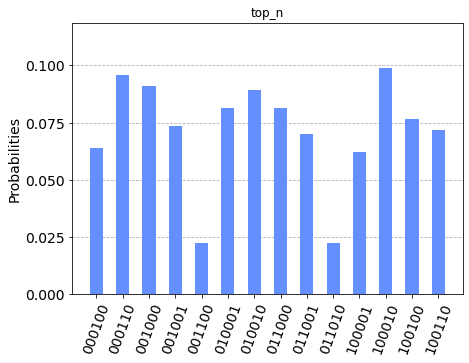

In [64]:
p3 = []
pause2 = results.get_counts()
pause2.clear()
di2 = dict.fromkeys(noisy_counts)
for i in di2.keys():
    p3.append([i,noisy_counts.get(i)])
p3.sort(key = lambda s: s[1],reverse = True)
print(p3)
for i in range(top_n):
        b = p3[i]
        pause2.setdefault(b[0],b[1])
plot_histogram(pause2, title="top_n",bar_labels = False)

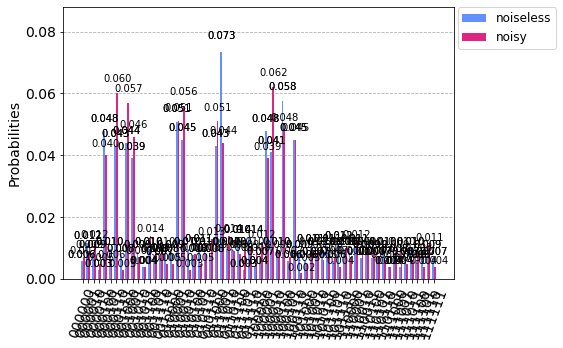

In [65]:
plot_histogram([counts, noisy_counts], legend=['noiseless', 'noisy'])

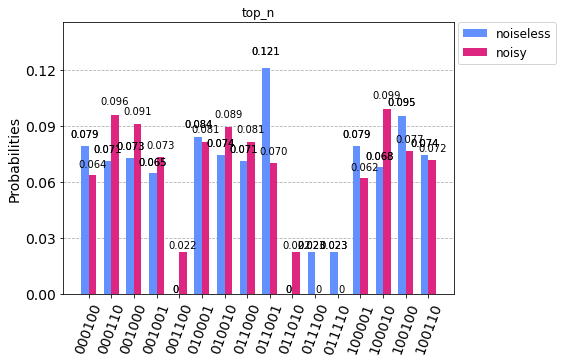

In [66]:
plot_histogram([pause, pause2], title="top_n", legend=['noiseless', 'noisy'])